## Derivative of a simple function with one input

In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def f(x):
  return 3*x**2 - 4*x + 5

In [3]:
f(3.0)

20.0

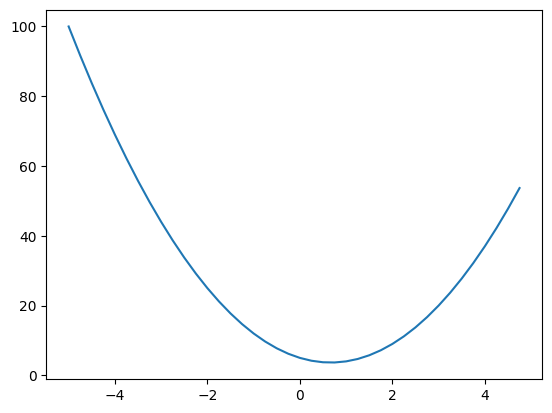

In [6]:
# A set of scalar values to make a numpy array
xs = np.arange(-5, 5, 0.25) ## -5 to 5 (not including 5) with steps of 0.25
ys = f(xs)
plt.plot(xs, ys)

In [11]:
h = 0.001
x = 2/3
(f(x+h) - f(x))/h

0.0029999999995311555

In [12]:
a = 2.0
b = -3.0
c = 10.0
d = a*b + c
print(d)

4.0


In [15]:
h = 0.0001

# inputs
a = 2.0
b = -3.0
c = 10.0

d1 = a*b + c
c += h
d2 = a*b + c

print('d1 ', d1)
print('d2 ', d2)
print('slope ', (d2-d1)/h)


d1  4.0
d2  4.0001
slope  0.9999999999976694


This is a numerical derivative. The primary reason for calculating the slope between two functions (or, more precisely, the change in a function's output with respect to a small change in one of its inputs) is to approximate the derivative.

## Building a value object

Here, init and repr are operators in the object. __init__ is an initializer. __repr__ means printable representation of the given object.

We need to have a connective tissue of this expression. We need to know and keep pointers about what values produce other values. For this, we introuduce a new variable _children, a tuple.

The 'operation' that created the resulting value will be denoted by _op. For addition, it will return '+'.

Also, grad maintains the derivative of L w.r.t. that value. We're adding this as self.grad = 0 => means the default gradient = 0. basically initializing the gradient.

We will also add labels so that we'll know what variables are where.

In [88]:
class Value:
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data # takes a single scalar value that it wraps and keeps track of
        self.grad = 0.0
        self._prev = set(_children) #_prev is a set
        self._op = _op
        self.label = label

    def __repr__(self): # this is a wrapper. providing us a nicer looking printout.
        return f"Value(data={self.data})"

    def __add__(self, other):
        out = Value(self.data + other.data, (self, other), '+') # '+' here is not the + for numbers, it's a floating point + addition
        return out

    def __mul__(self, other):
        out = Value(self.data * other.data, (self, other), '*')
        return out

    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1) / (math.exp(2*x) + 1)
        out = Value(t, (self, ), 'tanh')
        return out

a = Value(data=2.0, label='a')
b = Value(-3.0, label='b')
# a + b is basically doing a.__add__(b) here. Output: Value(data=-1.0)
c = Value (10.0, label='c')
e = a*b; e.label = 'e'
d = e + c; d.label = 'd'
f = Value(-2.0, label='f')
L = d * f; L.label = 'L'
L

Value(data=-8.0)

In [55]:
d._prev

{Value(data=-6.0), Value(data=10.0)}

In [56]:
d._op

'+'

In [57]:
# some scary ass code for visualization
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right

  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

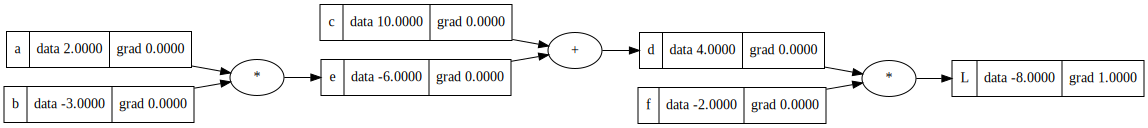

In [60]:
draw_dot(L)

##Backpropagation

The above visualization is visualizing the forward pass (output is -8).

Now, we want to run backpropagation, esentially start from L, travel the reverse direction, and calculate the gradient of all the intermediate values along the way.

In other words, for every single intermediate value, we will be calculating the derivative of that node w.r.t. L.

### Manual Backpropagation

In [59]:
L.grad = 1 # because derivative of L w.r.t. to L is 1

In [61]:
#we can numerically verify the gradients as well by adding h to the individual variables in the lol() function.
def lol(): # staging area for backprop
    h = 0.0001 # adding a small amount of h

    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value (10.0, label='c')
    e = a*b; e.label = 'e'
    d = e + c; d.label = 'd'
    f = Value(-2.0, label='f')
    L = d * f; L.label = 'L'
    L1 = L.data

    a = Value(2.0 + h, label='a') # adding h to a, measuring the deriative of L w.r.t. a
    b = Value(-3.0, label='b')
    c = Value (10.0, label='c')
    e = a*b; e.label = 'e'
    d = e + c; d.label = 'd'
    f = Value(-2.0, label='f')
    L = d * f; L.label = 'L'
    L2 = L.data

    print((L2 - L1) / h) # rise over run (deriative of L w.r.t. a)

lol()

6.000000000021544


## Now, let's look at the derivatives of L w.r.t. d and f.

L = d * f
we want to know what dL/dd is.

dL/dd = ?

definition of derivative is: (f(x+h) - f(x)) / h

=> (f(x+h)-f(x))/h

=> ((d+h)*f - d*f)/h

=> (d*f + h*f - d*f) / h

=> (h*f)/h

=> f

similarly, dL/df will be just d. gradient for one is basically the value of the other (for d and f).


In [62]:
# manually setting
f.grad = 4.0
d.grad = -2.0

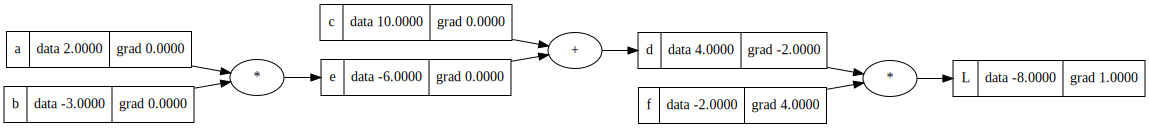

In [63]:
draw_dot(L)

##Most important part for this backpropagation

we can see above that d affects L directly, and c has a direct effect on d which means obviously c has some indirect effect on L

lets find dd/dd=?

d = c + e

so, using the definition of the derivative:

dd / dc = 1.0

dd / de = 1.0

CHAIN RULE: dy/dx = (dy/du) * (du/dx)

WANT:
dL / dc

WE KNOW:
dL / dd and dd / dc

=> dL /d c

=> (dL / dd) * (dd / dc)

=> -2.0 (dd/dc was 1 so we can think of dL/dc as dL/dd)


In [64]:
c.grad = -2.0
e.grad = -2.0 # by symmetry

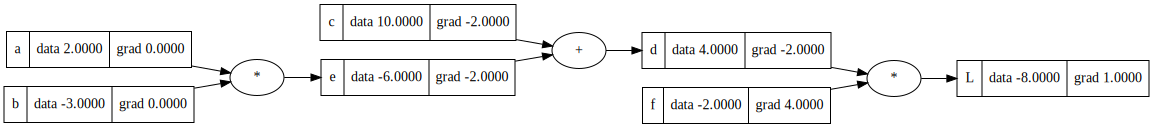

In [65]:
draw_dot(L)

##Recursing our way further backwards

WE KNOW:
dL / de = -2.0

WE WANT:
dL / da

this is basically:
dL / da = (dL / de) * (de / da)

de / da = ?

we know that: e = a * b

de / da = b (which is -3.0)

so,

=> dL / da = (dL / de) * (de / da)

=> (-2.0) * b

=> (-2.0) * (-3.0)

=> 6.0




In [66]:
a.grad = (-2.0 * -3.0)
b.grad = (-2.0 * 2.0) #by symmetry

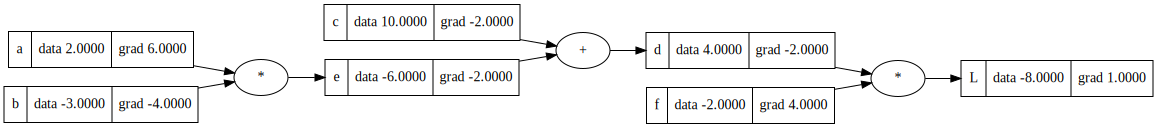

In [67]:
draw_dot(L)

This is basically what backpropagation is: iterating through all the nodes starting from the loss function L by locally applying the chain rule. So we just go through and recursively multiply on the local derivatives.

If we give the leaf nodes (basically the variables) a small nudge towards their gradients, we can expect a directly proportional effect on L.

In [68]:
# example of what's explained above
a.data += 0.01 * a.grad
b.data += 0.01 * b.grad
c.data += 0.01 * c.grad
f.data += 0.01 * f.grad

e = a * b
d = e + c
L = d * f

print(L.data)

-7.286496


A positive change in L's value brought by adding small fraction of individial leaf nodes' gradients to their initial values.

## Manual Backprop using NN

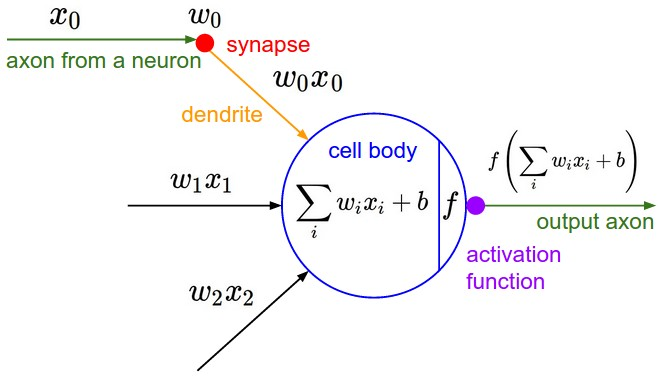

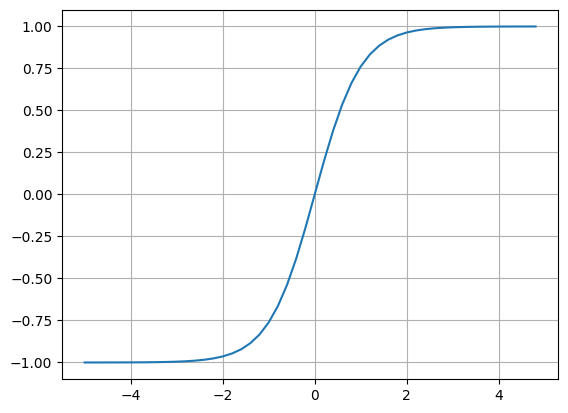

In [70]:
# squashing function example (tanh)
plt.plot(np.arange(-5,5,0.2), np.tanh(np.arange(-5,5,0.2))); plt.grid();

In [90]:
# inputs x1, x2 (a 2-dimensional neuron)
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

#weights w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

#bias of the neuron
b = Value(6.8813735870195432, label='b')

#basically what we're trying to do here is: x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'

n = x1w1x2w2 + b; n.label = 'n' #bascially is the activation without the activation function

o = n.tanh(); o.label = 'o' # this basically is o = tanh(n)

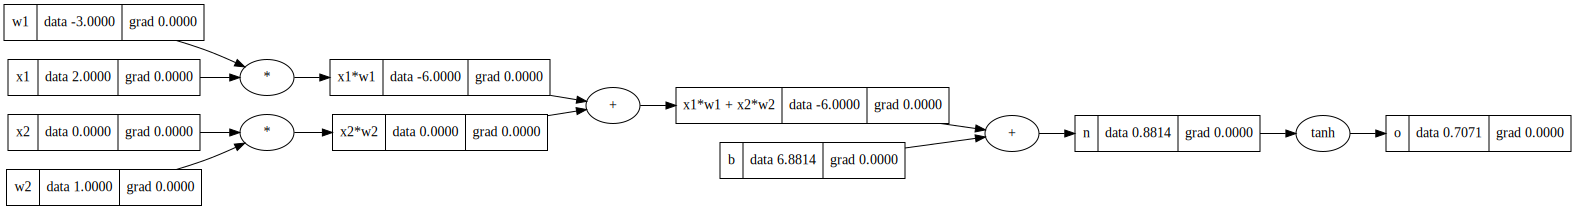

In [91]:
draw_dot(o)

starting backprop

In [92]:
o.grad = 1.0

We know that: o = tanh(n)

Derivative of tanh(x):

d(tan(x)) / dx = (1 - tan^2(x))

Therefore:

do / dn = 1 - o^2

In [93]:
1 - o.data**2

0.4999999999999999

In [94]:
n.grad = 0.5 # 1 - o.data**2 is 0.5

Similarly, as a chain rule:

d(o) / d(x1w1x2w1) = (d(o)/d(n)) * ((d(n)) / d(x1w1x2w1))


What we know: d(o) / d(n) = 0.5 (n.grad)

and:

n = x1w1x2w2 + b

So, the chain rule becomes:

=> 0.5 * (d(x1w1x2w2 + b) / d(x1w1x2w2)) $




Therefore, d(o) / d(x1w1x2w2) = 0.5

Similarly, by symmetry, d(o) / d(b) = 0.5.

In [95]:
x1w1x2w2.grad = 0.5
b.grad = 0.5

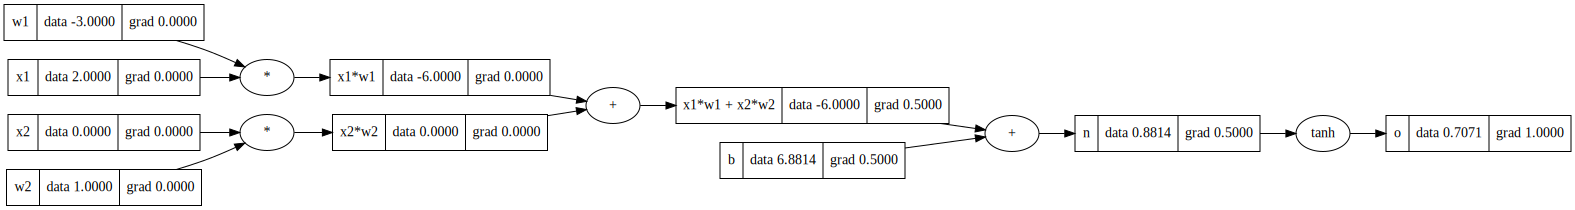

In [96]:
draw_dot(o)

In [99]:
# similarly for x1w1 and x2w2 since it also have a + operator
x1w1.grad = 0.5
x2w2.grad = 0.5

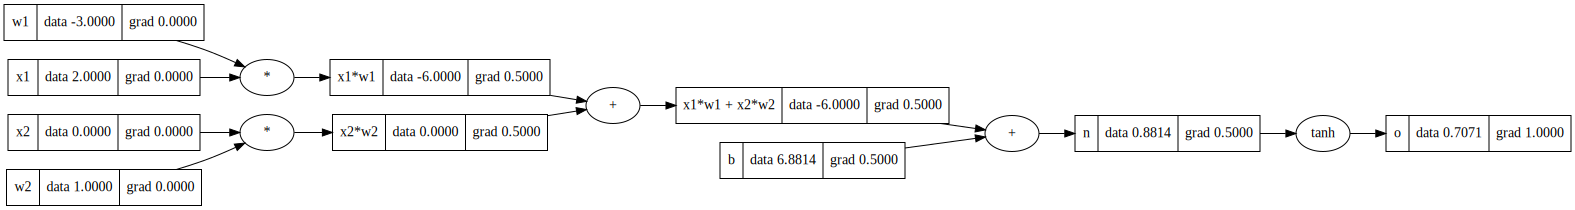

In [100]:
draw_dot(o)

x2.grad = ?

it is:

d(o) / d(x2) = (d(o) / d(x2w2)) * ((d(x2w2)) / d(x2))

=> 0.5 * w2

=> 0.5 * 1

=> 0.5

In [101]:
x2.grad = x2w2.grad * w2.data

w2.grad = x2w2.grad * x2.data

x2.grad, w2.grad

(0.5, 0.0)

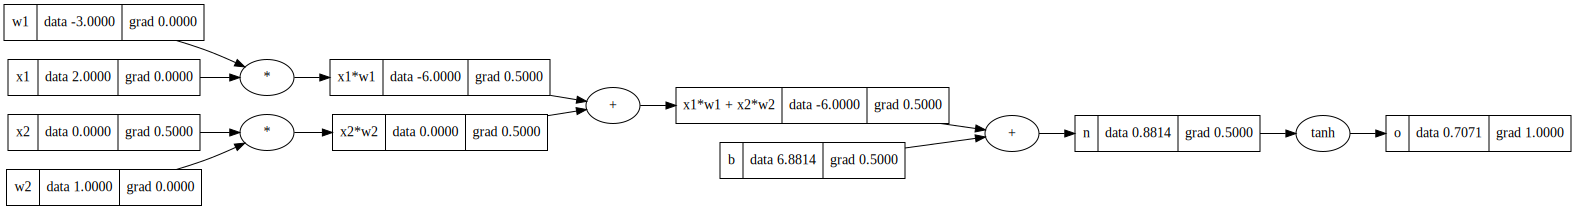

In [102]:
draw_dot(o)

In [103]:
x1.grad = x1w1.grad * w1.data
w1.grad = x1w1.grad * x1.data

x1.grad, w1.grad

(-1.5, 1.0)

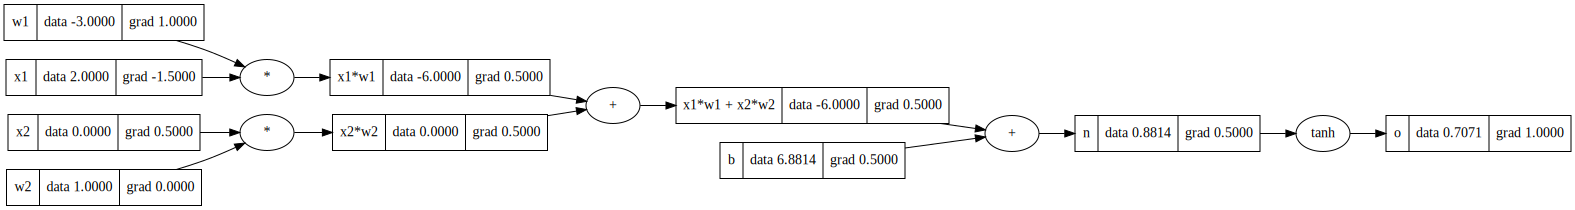

In [104]:
draw_dot(o)

## Implementing the Backward Function for Each Operation

rather than just doing every local derivative manually

again our logic will be the chain rule:

localderivative * global derivative for that expression

In [122]:
class Value:
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None

        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __repr__(self):
        return f"Value(data={self.data})"

    def __add__(self, other):
        out = Value(self.data + other.data, (self, other), '+')

        def _backward():
            self.grad = 1 * out.grad
            other.grad = 1 * out.grad

        out._backward = _backward
        return out

    def __mul__(self, other):
        out = Value(self.data * other.data, (self, other), '*')

        def _backward():
            self.grad = other.data * out.grad
            other.grad = self.data * out.grad
        out._backward = _backward
        return out

    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1) / (math.exp(2*x) + 1)
        out = Value(t, (self, ), 'tanh')

        def _backward():
            self.grad = (1 - t**2) * out.grad
        out._backward = _backward
        return out

a = Value(data=2.0, label='a')
b = Value(-3.0, label='b')
c = Value (10.0, label='c')
e = a*b; e.label = 'e'
d = e + c; d.label = 'd'
f = Value(-2.0, label='f')
L = d * f; L.label = 'L'
L

Value(data=-8.0)

In [123]:
# redefining all the values again so that every grad gets initialized to zero
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

b = Value(6.8813735870195432, label='b')

x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'

n = x1w1x2w2 + b; n.label = 'n'

o = n.tanh(); o.label = 'o'

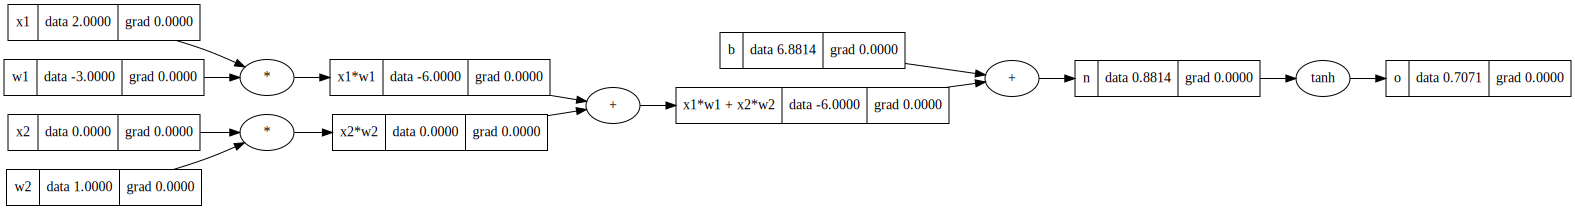

In [107]:
draw_dot(o)

In [109]:
o.grad = 1 # base case

In [110]:
o._backward() # propagates the grad through tanh(n)
# 0.5 gets pushed to n

In [111]:
n._backward() # 0.5 gets pushed to both x1w1x2w2 and b

In [114]:
b._backward() # nothing happens because b is a leaf node
#so the _backwards will follow the logic of the initialized self._backward = lambda: None

In [115]:
x1w1x2w2._backward() #gradient of 0.5 on each nodes

In [116]:
x1w1._backward()
x2w2._backward()

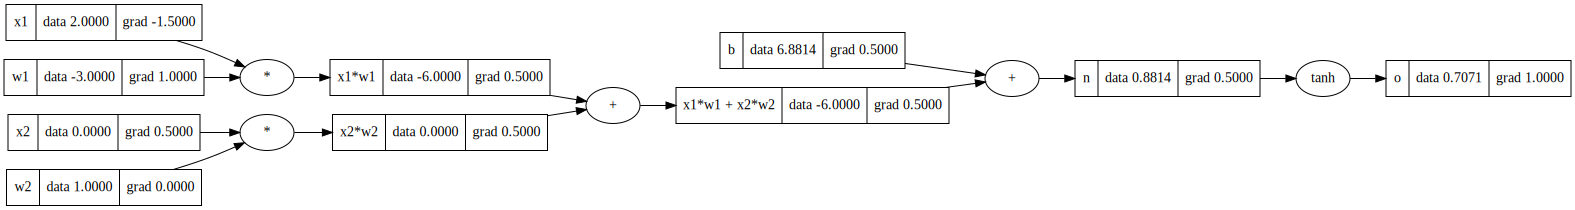

In [117]:
draw_dot(o)

## Implementing backward fn for a whole expression graph (using topological sort)

What we've been doing so far is doing the backprop manually from o back to the neuron's children, and since we're doing it one-by-one, we are ensuring that the sorting is always from right to left. When we automate it, we can't expect the neuron to simply do the sorting from right to left on its own, so that's why we need topological sorting.

In [127]:
o.grad = 1.0

topo = []
visited = set()
def build_topo(v):
    if v not in visited:
        visited.add(v)
        for child in v._prev:
            build_topo(child)
        topo.append(v) # appending is done only after the loop has visited all ther children

build_topo(o)

for node in reversed(topo): # reversing the topo order since it's originally from left to right, while we want it to be right to left.
    node._backward()

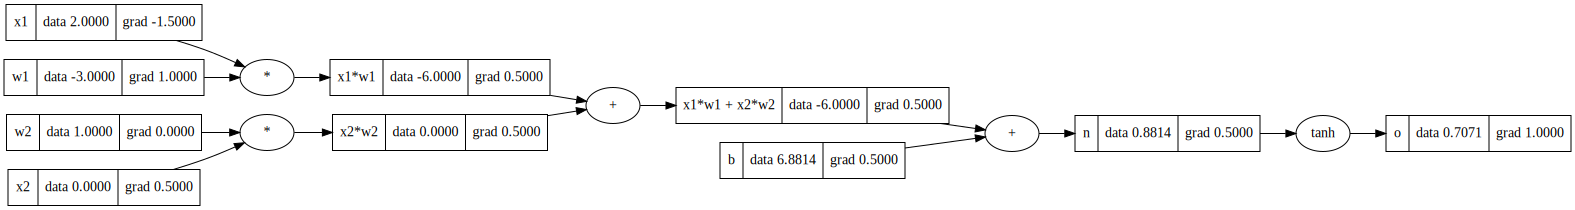

In [128]:
draw_dot(o)

adding everything together in value class


In [130]:
class Value:

    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0

        self._backward = lambda: None

        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __repr__(self):
        return f"Value(data={self.data})"

    def __add__(self, other):
        out = Value(self.data + other.data, (self, other), '+')

        def _backward():
            self.grad = 1 * out.grad
            other.grad = 1 * out.grad

        out._backward = _backward
        return out

    def __mul__(self, other):
        out = Value(self.data * other.data, (self, other), '*')

        def _backward():
            self.grad = other.data * out.grad
            other.grad = self.data * out.grad
        out._backward = _backward
        return out

    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1) / (math.exp(2*x) + 1)
        out = Value(t, (self, ), 'tanh')

        def _backward():
            self.grad = (1 - t**2) * 1
        out._backward = _backward
        return out

    def backward(self):

        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)
        self.grad = 1.0

        for node in reversed(topo):
            node._backward()


a = Value(data=2.0, label='a')
b = Value(-3.0, label='b')
c = Value (10.0, label='c')
e = a*b; e.label = 'e'
d = e + c; d.label = 'd'
f = Value(-2.0, label='f')
L = d * f; L.label = 'L'
L

Value(data=-8.0)

In [131]:
# redefining all the values again so that every grad gets initialized to zero
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

b = Value(6.8813735870195432, label='b')

x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'

n = x1w1x2w2 + b; n.label = 'n'

o = n.tanh(); o.label = 'o'

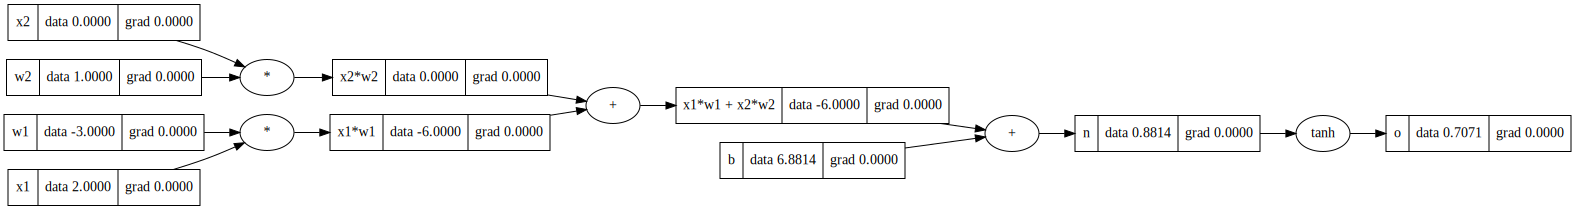

In [132]:
draw_dot(o)

In [133]:
o.backward()

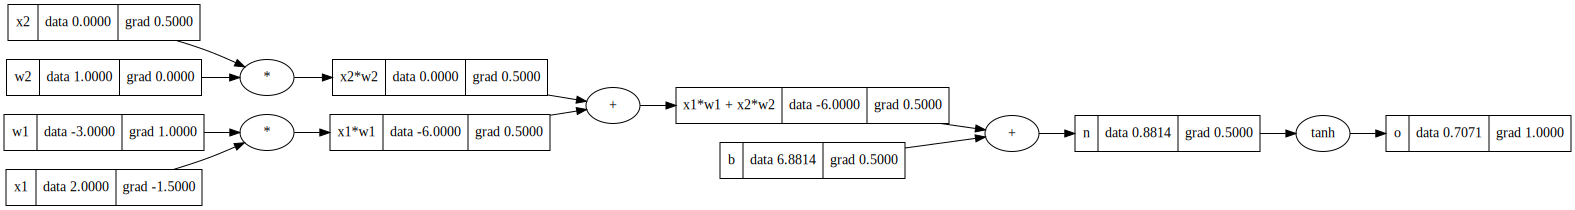

In [134]:
draw_dot(o)

## Unexpected bug in backwards

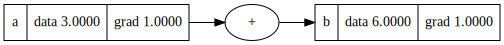

In [135]:
a = Value(3.0, label = 'a')
b = a + a ; b.label = 'b'
b.backward()
draw_dot(b)

There is a bug here. Our main issue here is that until now, we have been using our variables only once, so the gradients were getting calculated correctly and we did not notice any gradient errors.

For the code below, we are using a two times for b, and we can see from the graph that b.backward() is calculating the gradient of b with respect to a twice. This is why we are getting the wrong gradient for a as 1 instead of 2 (since (d(2a) / da) = 2)

However, the gradient is 1 in the diagram because when we look at the _backward part of the Value class, we are doing self.grad = other.data * out.grad as well as other.grad = self.data * out.grad, which means that we are basically overwriting the gradient of a with yet another gradient of a (which is 1) INSTEAD of adding the gradient to the existing gradient. We did not notice this before because we were using the variables only once. However, in this case, we are using a twice, so the gradient is getting overwritten.

we can solve this by adding the gradients instead of overwriting them

In [136]:
class Value:

    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0

        self._backward = lambda: None

        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __repr__(self):
        return f"Value(data={self.data})"

    def __add__(self, other):
        out = Value(self.data + other.data, (self, other), '+')

        def _backward():
            self.grad += 1 * out.grad #accumulating the gradients
            other.grad += 1 * out.grad #accumulating the gradients

        out._backward = _backward
        return out

    def __mul__(self, other):
        out = Value(self.data * other.data, (self, other), '*')

        def _backward():
            self.grad += other.data * out.grad #accumulating the gradients
            other.grad += self.data * out.grad #accumulating the gradients
        out._backward = _backward
        return out

    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1) / (math.exp(2*x) + 1)
        out = Value(t, (self, ), 'tanh')

        def _backward():
            self.grad += (1 - t**2) * 1 #accumulating the gradients
        out._backward = _backward
        return out

    def backward(self):

        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)
        self.grad = 1.0

        for node in reversed(topo):
            node._backward()


a = Value(data=2.0, label='a')
b = Value(-3.0, label='b')
c = Value (10.0, label='c')
e = a*b; e.label = 'e'
d = e + c; d.label = 'd'
f = Value(-2.0, label='f')
L = d * f; L.label = 'L'
L

Value(data=-8.0)

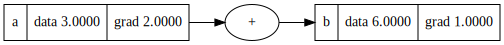

In [137]:
a = Value(3.0, label = 'a')
b = a + a ; b.label = 'b'
b.backward()
draw_dot(b)

## Cleaned version of the value class

In [138]:
class Value:
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0

        self._backward = lambda: None

        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __repr__(self):
        return f"Value(data={self.data})"

    def __add__(self, other):
        out = Value(self.data + other.data, (self, other), '+')

        def _backward():
            self.grad += 1 * out.grad
            other.grad += 1 * out.grad

        out._backward = _backward
        return out

    def __mul__(self, other):
        out = Value(self.data * other.data, (self, other), '*')

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        return out

    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1) / (math.exp(2*x) + 1)
        out = Value(t, (self, ), 'tanh')

        def _backward():
            self.grad += (1 - t**2) * 1
        out._backward = _backward
        return out

    def backward(self):

        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)
        self.grad = 1.0

        for node in reversed(topo):
            node._backward()

##Breaking up tanh, exercising with more operations

We will get the same result as before, but breaking it up into individual operations allows us to get a better perspective on the individual steps for calculating tanh.

### Ensuring that we can add numbers and floats to the variables directly

In [139]:
class Value:

    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0

        self._backward = lambda: None

        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __repr__(self):
        return f"Value(data={self.data})"

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other) # this is ensuring that we can add the numbers to the variables directly as well. Otherwise, we cannot really add numbers to variables like `a + 1` because 1 wouldn't have other.data because that makes no sense.

        out = Value(self.data + other.data, (self, other), '+')

        def _backward():
            self.grad += 1 * out.grad
            other.grad += 1 * out.grad

        out._backward = _backward
        return out

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)

        out = Value(self.data * other.data, (self, other), '*')

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        return out

    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1) / (math.exp(2*x) + 1)
        out = Value(t, (self, ), 'tanh')

        def _backward():
            self.grad += (1 - t**2) * 1
        out._backward = _backward
        return out

    def backward(self):

        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)
        self.grad = 1.0

        for node in reversed(topo):
            node._backward()

In [140]:
# this should ensure the following work:

a = Value(2.0)
a + 1, a* 2

(Value(data=3.0), Value(data=4.0))

But still 2 * a wont work!

So we are going to use __rmul__ to fix that

This is a method that is called when the object is on the right side of the multiplication operator. Basically, it is a fallback for the * operator. If, by any chance, Python can't do 2 * a, it will check if it can do a * 2 instead. This is done by the __rmul__ method. The __rmul__ method reverses the order of the operands for the multiplication.

In [143]:
class Value:
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0

        self._backward = lambda: None

        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __repr__(self):
        return f"Value(data={self.data})"

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)

        out = Value(self.data + other.data, (self, other), '+')

        def _backward():
            self.grad += 1 * out.grad
            other.grad += 1 * out.grad

        out._backward = _backward
        return out

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)

        out = Value(self.data * other.data, (self, other), '*')

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        return out

    def __rmul__(self, other):
        return self * other

    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1) / (math.exp(2*x) + 1)
        out = Value(t, (self, ), 'tanh')

        def _backward():
            self.grad += (1 - t**2) * 1
        out._backward = _backward
        return out

    def backward(self):

        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)
        self.grad = 1.0

        for node in reversed(topo):
            node._backward()


In [144]:
a = Value(2.0)

2 * a

Value(data=4.0)

## Building up the tanh function

We need to implement how to exponentiate (e
) and divide (/
) in our Value class

For mplementing the division

Instead of implementing the division directly, we can just implement the reciprocal of the denominator and then multiply the numerator with the reciprocal of the denominator.

=> a/b = a * (1/b)

=> a*b^-1

For implementing the subtraction function

Similar to how we implemented division with the help of multiplication, we can implement subtraction by implementing the negation function and then adding the two values.

=> a - b = a + (-b)



In [145]:
class Value:

    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0

        self._backward = lambda: None

        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __repr__(self):
        return f"Value(data={self.data})"

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)

        out = Value(self.data + other.data, (self, other), '+')

        def _backward():
            self.grad += 1 * out.grad
            other.grad += 1 * out.grad

        out._backward = _backward
        return out

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)

        out = Value(self.data * other.data, (self, other), '*')

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        return out

    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int/float powers for now"
        out = Value(self.data**other, (self, ), f'**{other}')

        def _backward():
            self.grad += other * (self.data ** (other - 1)) * out.grad # derivative of x^n is n*x^(n-1)
        out._backward = _backward
        return out

    def __rmul__(self, other):
        return self * other

    def __radd__(self, other):
        return self + other

    def __truediv__(self, other):
        return self * other**-1 # a / b = a * (1/b) = a * b^-1

    def __neg__(self): # -self, the negation of a value
        return self * -1

    def __sub__(self, other): # self - other, subtraction
        return self + (-other) # a - b = a + (-b)

    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1) / (math.exp(2*x) + 1)
        out = Value(t, (self, ), 'tanh')

        def _backward():
            self.grad += (1 - t**2) * out.grad
        out._backward = _backward
        return out

    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), 'exp')

        def _backward():
            self.grad += out.data * out.grad
        out._backward = _backward
        return out

    def backward(self):

        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)
        self.grad = 1.0

        for node in reversed(topo):
            node._backward()

### Breaking up tanh into indivisual operations

tanh(x) = ((e^2x) -1) / ((e^2x) + 1)

In [146]:
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

b = Value(6.8813735870195432, label='b')

x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'

n = x1w1x2w2 + b; n.label = 'n'
e = (2*n).exp() # this means e = exp to the power of 2n

o = (e - 1) / (e + 1)
o.backward()

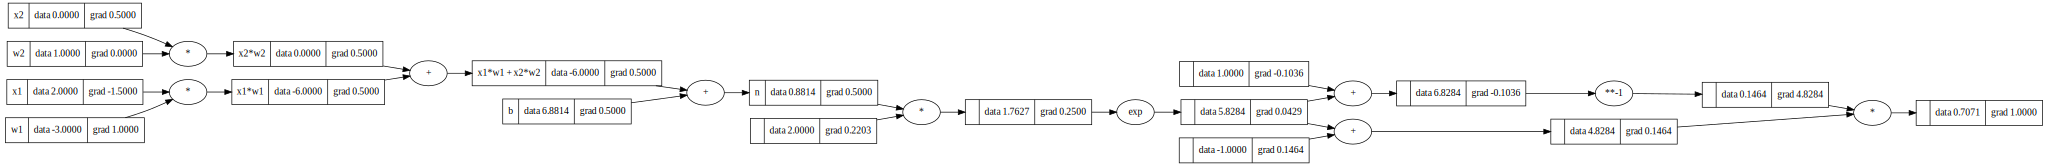

In [147]:
draw_dot(o)

this reveals to us that it doesn't really matter that much how we break down the operations, as long as we can calculate the gradients correctly and are able to do the forward as well as the backward passes.



## Doing the same thing in PyTorch

In [148]:
import torch

We are defining the variables as requires_grad=True so that PyTorch knows that it needs to calculate the gradients for these variables. It's set to False by default.

We are defining the operations as torch operations.

The .double() is used to convert the variables to float64. This is because Python uses float64 by default, but the default element datatype for torch.Tensor() is float32. We want to make sure that we are comparing apples to apples.

The .item() is used to get the actual value of the tensor. This is because the tensor itself is a wrapper around the actual value, and we need to get the actual value to compare it with our implementation.

Also, torch already has its own backward() function, so we don't need to implement it ourselves. We can just call loss.backward() and it will calculate the gradients for us.

In [149]:
x1 = torch.Tensor([2.0]).double(); x1.requires_grad = True
x2 = torch.Tensor([0.0]).double(); x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double(); w1.requires_grad = True
w2 = torch.Tensor([1.0]).double(); w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double(); b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print('o:', o.item())
o.backward()

print('-----')
print('x2:', x2.grad.item())
print('w2:', w2.grad.item())
print('x1:', x1.grad.item())
print('w1:', w1.grad.item())

o: 0.7071066904050358
-----
x2: 0.5000001283844369
w2: 0.0
x1: -1.5000003851533106
w1: 1.0000002567688737


In [151]:
torch.Tensor([[1, 2, 3], [4, 5, 6]])

tensor([[1., 2., 3.],
        [4., 5., 6.]])

## Building Out A Multi-Layer Perceptron in Micrograd

### Starting with a single individual neuron

In [162]:
import random

class Neuron:
  def __init__(self, nin):
      self.w = [Value(random.uniform(-1, 1)) for _ in range(nin)] ## means that we're initializing the weights randomly between -1 and 1 for each input
      self.b = Value(random.uniform(-1, 1))

  # __call__ is a special method in Python classes that allows us to call the object like a function
  def __call__(self, x):
    # w * x + b
    # print(list(zip(self.w, x)))
    activation = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
    out = activation.tanh()
    return out

class Layer:
    def __init__(self, nin, nout):
        # Here, nin is the number of inputs to the layer, and nout is the number of neurons in the layer

        self.neurons = [Neuron(nin) for _ in range(nout)] # # we're creating nout neurons in the layer, each with nin input (the dimensionality)

    def __call__(self, x): # here, x is the input to the layer. It's a list of nin numbers, where nin is the number of inputs to the layer.
        outs = [n(x) for n in self.neurons]
        return outs

x = [2.0, 3.0]

# n = Neuron(2)
n = Layer(2,3)

n(x) # The () operator is a shorthand for the __call__ method. So, when we do n(x), it's the same as doing n.__call__(x).


[Value(data=-0.9974753856742208),
 Value(data=0.8371570506903161),
 Value(data=0.9829821320668337)]

## Creating a MLP with 2 hidden layers

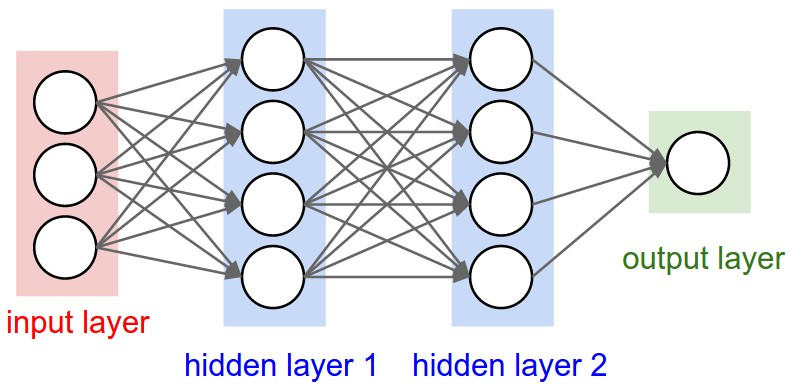

In [166]:
import random

class Neuron:
    def __init__(self, nin):
        self.w = [Value(random.uniform(-1, 1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1, 1))

    def __call__(self, x):
        activation = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
        out = activation.tanh()
        return out

class Layer:
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]

    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs

class MLP:
    def __init__(self, nin, nouts):
        size = [nin] + nouts
        self.layers = [Layer(size[i], size[i+1]) for i in range(len(size) - 1)]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])
n(x)

Value(data=-0.6318547162769692)

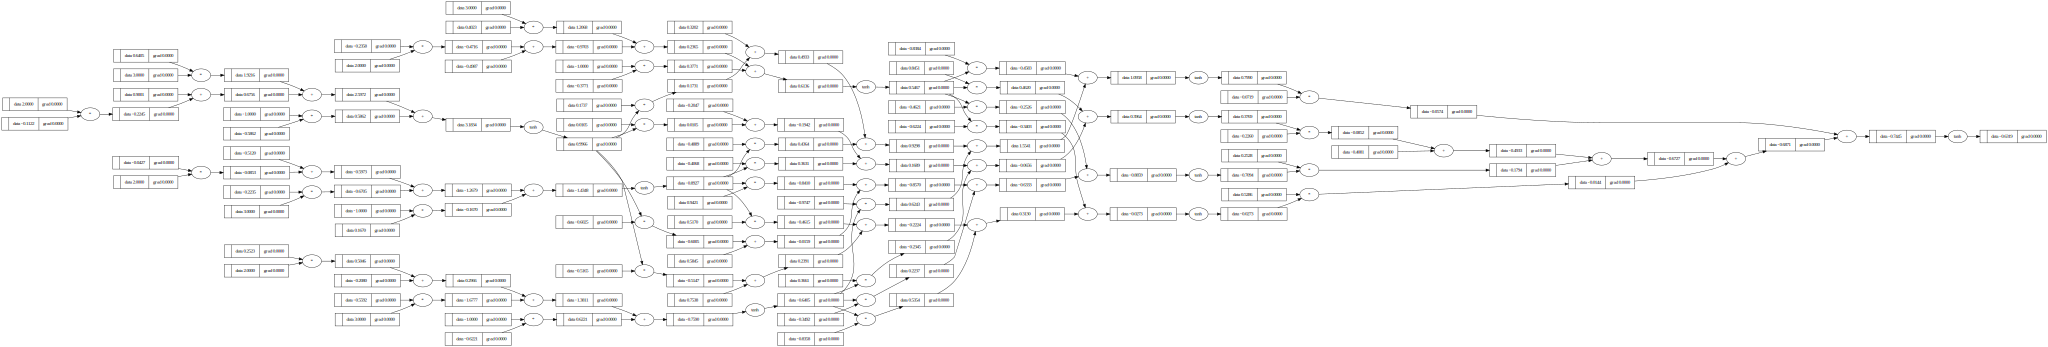

In [167]:
draw_dot(n(x))

## Creating a Tiny Dataset & Writing the Loss Function

In [172]:
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]

ys = [1.0, -1.0, -1.0, 1.0] # desired targets

ypred = [n(x) for x in xs]

ypred

[Value(data=-0.6318547162769692),
 Value(data=0.1857878948747386),
 Value(data=0.1461282956263816),
 Value(data=-0.6522739939498625)]

In [173]:
loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))
loss

Value(data=8.112662167785317)

In [174]:
loss.backward()

In [175]:
n.layers[0].neurons[0].w[0].grad

-1.6291452074551243

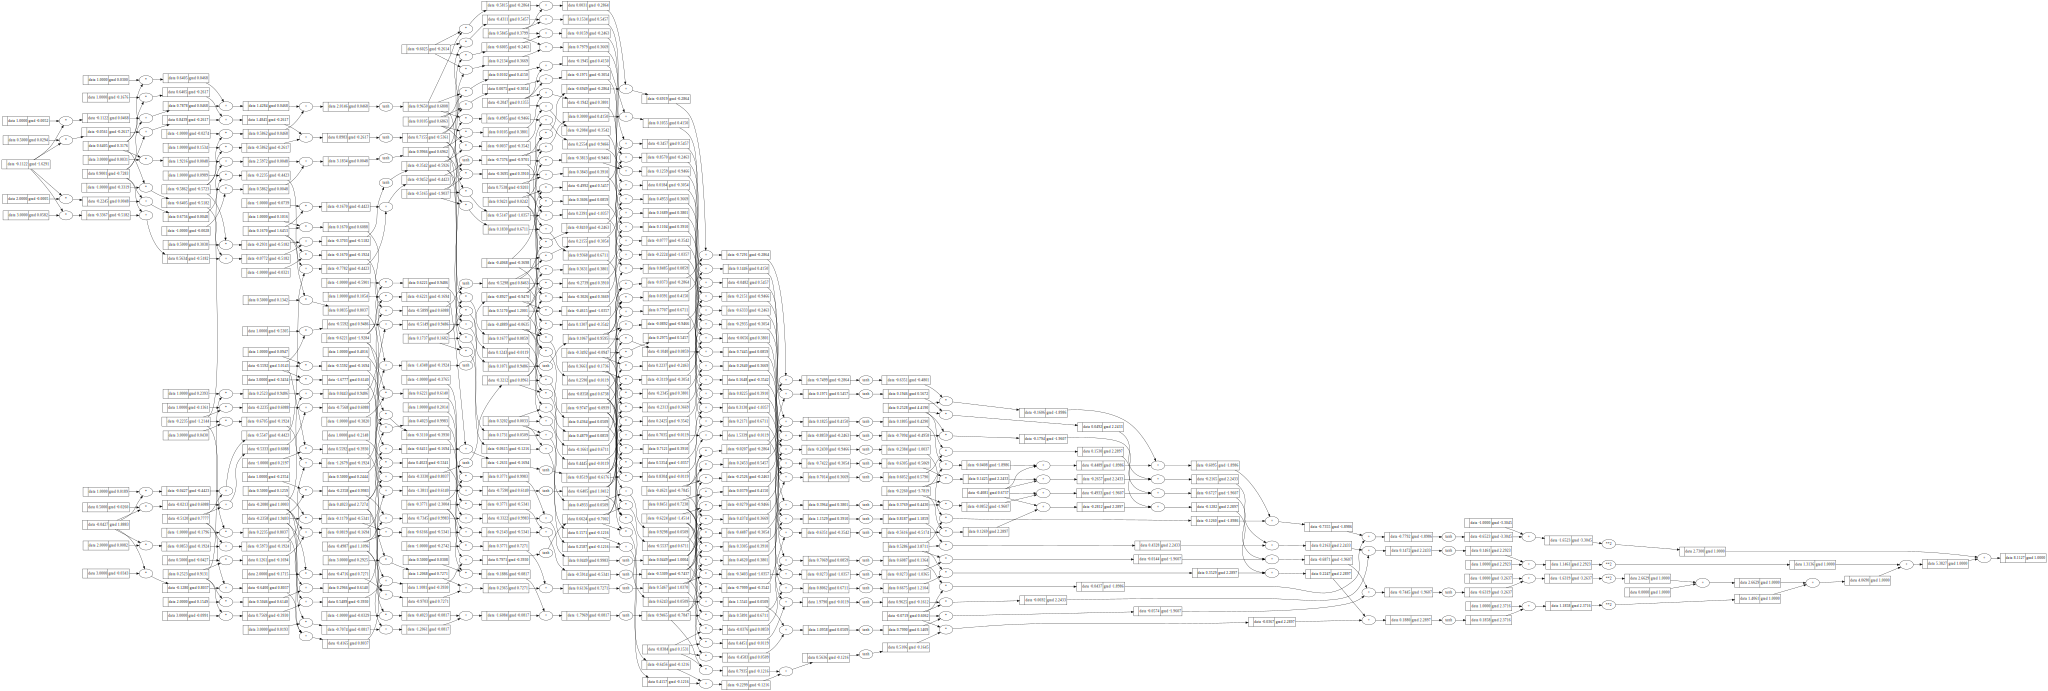

In [176]:
draw_dot(loss)

## Collecting all the Parameters of the Neural Network

In [177]:
import random

class Neuron:
    def __init__(self, nin):
        self.w = [Value(random.uniform(-1, 1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1, 1))

    def __call__(self, x):
        activation = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
        out = activation.tanh()
        return out

    def parameters(self): # addition of the parameter method to collect all the parameters of the neuron so that we can collectively nudge them when we need to minimize the loss
        return self.w + [self.b]

class Layer:
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]

    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs

    def parameters(self):
        params = []
        for neuron in self.neurons:
            ps = neuron.parameters()
            params.extend(ps)
        return params
    # or a shorter to write the parameters method is:
    # def parameters(self):
        # return [p for neuron in self.neurons for p in neuron.parameters()]

class MLP:
    def __init__(self, nin, nouts):
        size = [nin] + nouts
        self.layers = [Layer(size[i], size[i+1]) for i in range(len(size) - 1)]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

    def parameters(self):
        params = []
        for layer in self.layers:
            ps = layer.parameters()
            params.extend(ps)
        return params
    # or a shorter to write the parameters method is:
    # def parameters(self):
        # return [p for layer in self.layers for p in layer.parameters()]


In [178]:
x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])
n(x)

Value(data=-0.8783613506179992)

In [179]:
n.parameters()

[Value(data=-0.14898148889201934),
 Value(data=-0.3274117154497178),
 Value(data=0.5296668595629153),
 Value(data=-0.8584928347247809),
 Value(data=-0.7188809038708719),
 Value(data=-0.4018221864615441),
 Value(data=-0.24389943714008333),
 Value(data=0.35107031920017806),
 Value(data=0.1446370468511644),
 Value(data=0.41699579563860634),
 Value(data=0.7502286803454863),
 Value(data=-0.6556025952110294),
 Value(data=-0.3490749834495117),
 Value(data=-0.3588188227369953),
 Value(data=-0.39756951754153236),
 Value(data=-0.9760587439739636),
 Value(data=0.030841938521902534),
 Value(data=-0.6243852012608135),
 Value(data=0.16172881897989821),
 Value(data=-0.7066568826967841),
 Value(data=-0.924315004971501),
 Value(data=0.6787797535213294),
 Value(data=-0.32512919755687464),
 Value(data=0.28099206133361165),
 Value(data=0.8625346070850479),
 Value(data=0.8776337739313469),
 Value(data=0.7153469832134642),
 Value(data=0.24195221210329954),
 Value(data=0.2801098999645397),
 Value(data=0.2340

In [180]:
len(n.parameters())

41

In [181]:
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]

ys = [1.0, -1.0, -1.0, 1.0] # desired targets

[Value(data=-0.8783613506179992),
 Value(data=-0.8896750383608313),
 Value(data=-0.8868198286036616),
 Value(data=-0.8314218188991446)]

In [ ]:
ypred = [n(x) for x in xs]

ypred

### Old Loss

In [182]:
ypred = [n(x) for x in xs]
loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))
loss

Value(data=6.907328590593314)

In [183]:
loss.backward()

In [184]:
n.layers[0].neurons[0].w[0].grad

0.005351222566192479

In [185]:
n.layers[0].neurons[0].w[0].data

-0.14898148889201934

## Doing the Gradient Descent Optimization Manually, Training the Neural Network

In [290]:
for p in n.parameters():
  p.data += -0.01 * p.grad

In [291]:
loss.backward()

In [292]:
n.layers[0].neurons[0].w[0].data

2.374220800187211

### New loss

In [293]:
ypred = [n(x) for x in xs]
loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))
loss

Value(data=0.008192495947653828)

In [294]:
ypred

[Value(data=0.9104541780582077),
 Value(data=-0.9918628451701239),
 Value(data=-0.9920125900226348),
 Value(data=0.9933645110541294)]

In [295]:
 n.parameters()

[Value(data=2.374220800187211),
 Value(data=-0.7752074578707397),
 Value(data=2.4047113596013237),
 Value(data=0.5709746806063712),
 Value(data=-0.44065264337854726),
 Value(data=-0.06433218968662231),
 Value(data=-0.48669310885881367),
 Value(data=0.6243221859280115),
 Value(data=1.097173472235398),
 Value(data=-0.6909087407121434),
 Value(data=2.1488079267162354),
 Value(data=-0.08790292245254729),
 Value(data=-0.2682588029684601),
 Value(data=-0.5113154144516279),
 Value(data=-0.17131222091735754),
 Value(data=-0.9742438347421896),
 Value(data=0.4502426136910599),
 Value(data=-0.4973247859849642),
 Value(data=0.4724002523871159),
 Value(data=-0.5249464876437496),
 Value(data=-1.1390741373482884),
 Value(data=1.1191229493319814),
 Value(data=-0.4787053412483214),
 Value(data=1.0317731322433654),
 Value(data=0.8633053947716232),
 Value(data=0.8318967621691572),
 Value(data=0.859432887248102),
 Value(data=-0.08072409620834131),
 Value(data=0.7524878808522347),
 Value(data=-0.1286081677

## Making it a bit better through looping

In [296]:
x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])
n(x)

Value(data=0.8498960656034946)

In [297]:
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]

ys = [1.0, -1.0, -1.0, 1.0]

In [387]:
for k in range(20): #20 as in 20 epochs

    # forward pass
    ypred = [n(x) for x in xs]

    loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))

    # backward pass
    for param in n.parameters():
        param.grad = 0.0 # reset the gradients to 0 before the backward pass
    loss.backward()

    # gradient descent step
    for param in n.parameters():
        param.data += -0.05 * param.grad

    print(k, loss.data)

0 0.0012534679590794455
1 0.0012500090778420295
2 0.0012465687334867399
3 0.0012431467790703194
4 0.001239743069188432
5 0.0012363574599556259
6 0.0012329898089857175
7 0.001229639975372298
8 0.0012263078196696712
9 0.0012229932038740926
10 0.0012196959914052502
11 0.0012164160470879972
12 0.001213153237134456
13 0.00120990742912632
14 0.0012066784919974479
15 0.0012034662960167266
16 0.0012002707127711748
17 0.0011970916151493548
18 0.0011939288773249526
19 0.0011907823747406934


In [388]:
ypred

[Value(data=0.9856907199013528),
 Value(data=-0.9811424742049244),
 Value(data=-0.9818240557184902),
 Value(data=0.9826778855747151)]